In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import random
import string
import os
import glob
import pickle as pkl
my_path = Path('/home/adameshel/Documents/code/autocorr/')
from autocorr_functions import *
import autocorr_cmls as accml

In [3]:
from pyproj import Proj, transform
import scipy.stats as stats
import sys
from pathlib import Path
# sys.path.append("../Iterative/")
# sys.path.append("../Kriging/")
sys.path.append("/home/adameshel/Documents/code/my_functions/")
from geoFunc import *
from analysis_funcs import *
import iterative_IDW_V1 as gmz
import kriging as krg
sys.path.append("/home/adameshel/Documents/code/") 
from helper_functions import *

In [4]:
my_path = Path('/home/adameshel/Documents/code/autocorr/semi_real/main/')
fig_path = my_path.joinpath('figures')

In [7]:
dir_paths = glob.glob(str(my_path.absolute()) + '/*/')
idxs = []
i = 0
for p in dir_paths:
    if '_cod' not in p:
        idxs.append(i)
    if '60T_ts29' in p:
        idxs.append(i)
    i+=1
dir_paths = delete_from_list(dir_paths,idxs)
dir_paths

['/home/adameshel/Documents/code/autocorr/semi_real/main/90T_ts20_cod50optTrue_identicalFalse_mult20_DzerosTrue_U/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/5T_ts360_cod40optTrue_identicalTrue_mult20_DzerosTrue_N/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/90T_ts20_cod50optTrue_identicalTrue_mult20_DzerosTrue_N/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/60T_ts8_cod100optTrue_identicalTrue_mult20_DzerosFalse_N/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/5T_ts360_cod40optTrue_identicalFalse_mult20_DzerosTrue_U/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/60T_ts8_cod100optTrue_identicalFalse_mult20_DzerosFalse_U/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/30T_ts49_cod70optTrue_identicalTrue_mult10_DzerosFalse_N/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/30T_ts26_cod70optTrue_identicalTrue_mult10_DzerosFalse_N/',
 '/home/adameshel/Documents/code/autocorr/semi_real/main/30T_ts49

/home/adameshel/Documents/code/autocorr/semi_real/main/90T_ts20_cod50optTrue_identicalFalse_mult20_DzerosTrue_U/
(50, 20)
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/90T_ts20_cod50_mult20_DzerosTrue
12.092626714963055 3.784976144241635
/home/adameshel/Documents/code/autocorr/semi_real/main/5T_ts360_cod40optTrue_identicalTrue_mult20_DzerosTrue_N/
(50, 20)
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/5T_ts360_cod40_mult20_DzerosTrue
7.431629096256386 18.631302918935763
/home/adameshel/Documents/code/autocorr/semi_real/main/90T_ts20_cod50optTrue_identicalTrue_mult20_DzerosTrue_N/
(50, 20)
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/90T_ts20_cod50_mult20_DzerosTrue
12.092626714963055 3.784976144241635
/home/adameshel/Documents/code/autocorr/semi_real/main/60T_ts8_cod100optTrue_identicalTrue_mult20_DzerosFalse_N/
(50, 20)
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/60T_ts8_cod100_mult20_DzerosFalse
24.741791369373964 4.50644

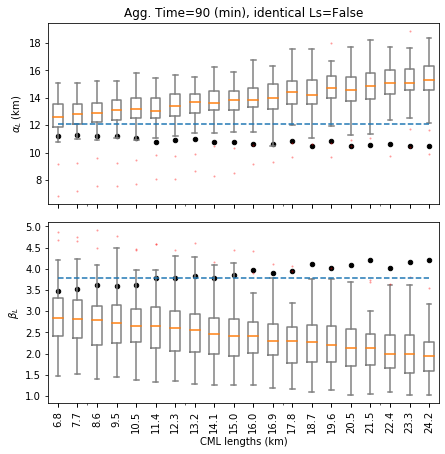

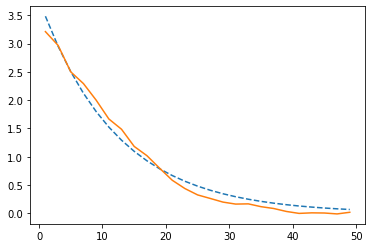

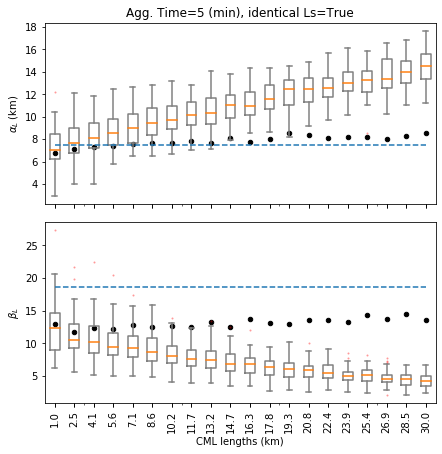

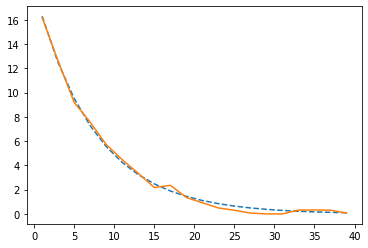

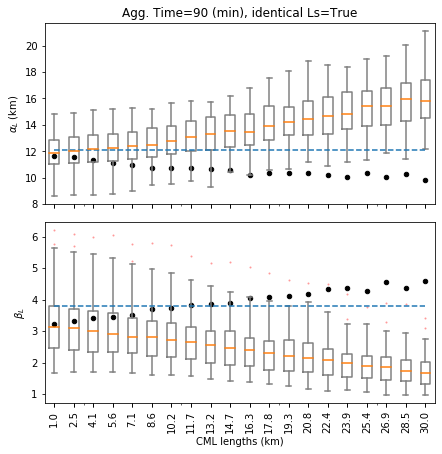

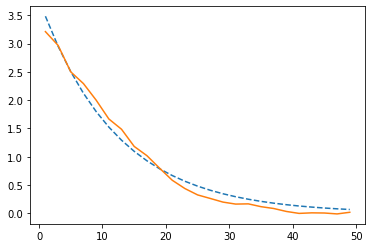

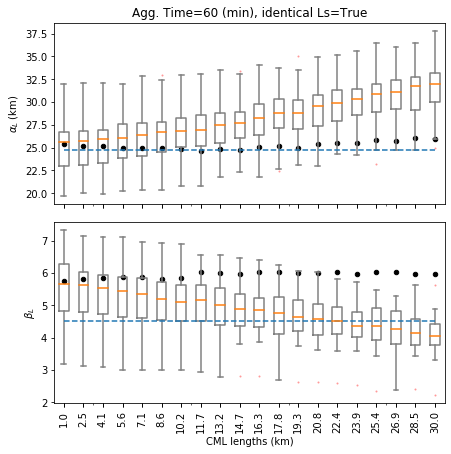

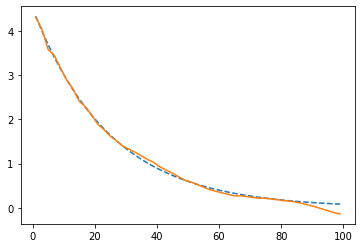

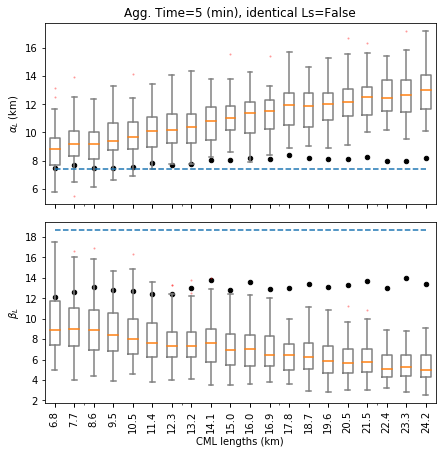

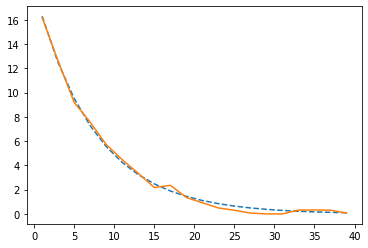

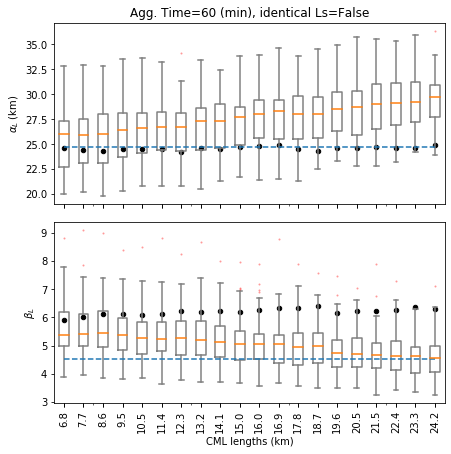

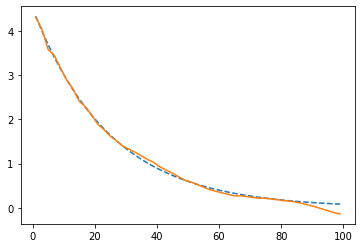

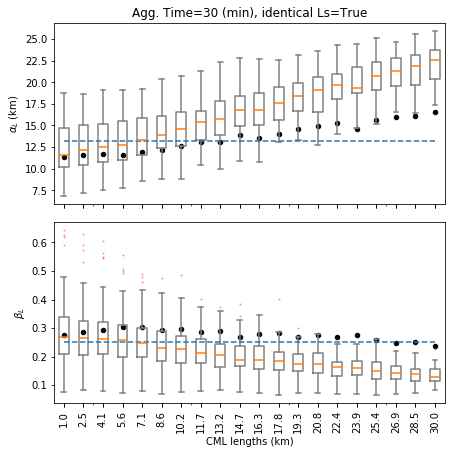

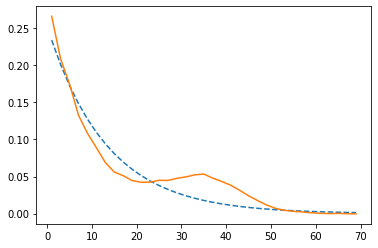

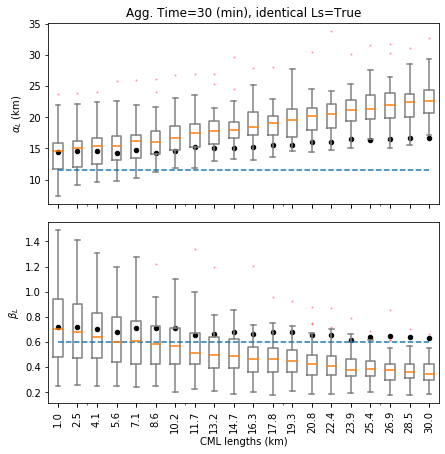

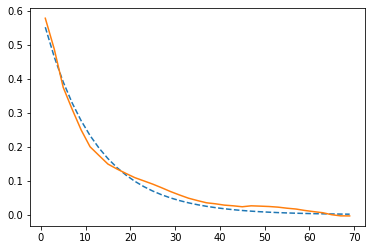

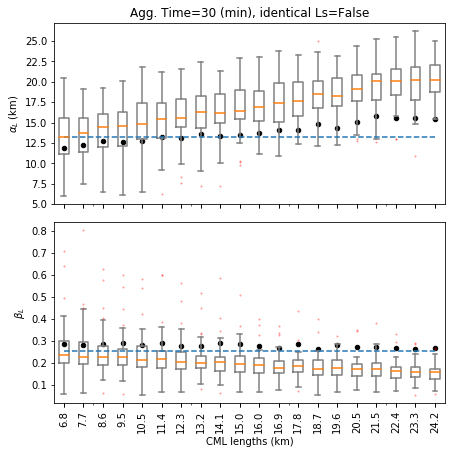

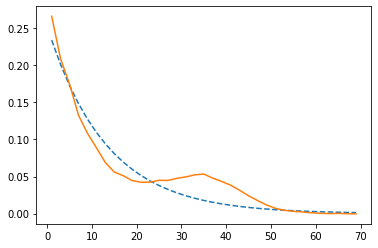

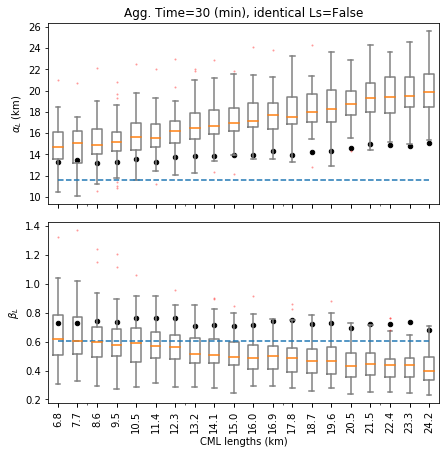

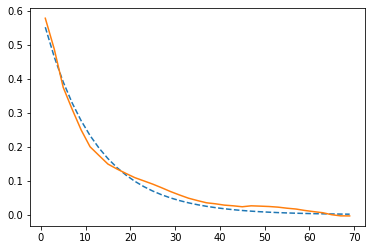

In [22]:
a = 0.2; b = 3.0;

list_of_snapshots = []
for i, dr in enumerate(dir_paths):
    sn = split_at(split_at(dr,'_',-5)[0] + \
    split_at(split_at(dr,'identical',1)[1],'_',1)[0],'/',-1)[1] +\
    'a_' + str(int(a*100)) + 'b_' + str(int(b*100))
    if sn not in list_of_snapshots:
        list_of_snapshots.append(sn)

def filter_par_arr(array):
    array[array[:,1]==888] = np.nan
    array[array[:,1]==777] = np.nan
    array[array[:,1]==666] = np.nan
    array[array[:,0] < 1e3] = np.nan
    array[array[:,1] > 600] = np.nan
    array[array[:,1] < 1e-2] = np.nan
    array[:,0] = array[:,0] / 1e3 # to make alpha units km
    return array

for i, dr in enumerate(dir_paths):
    if 'identicalFalse' in dr:
        identical = False
    else:
        identical = True
    sn = split_at(split_at(dr,'_',-5)[0] + \
    split_at(split_at(dr,'identical',1)[1],'_',1)[0],'/',-1)[1] +\
    'ab_' + str(int(a*100)) + str(int(b*100))
    if sn not in list_of_snapshots:
        list_of_snapshots.append(sn)
        
    dir_path_current = Path(dr)
#     print(dir_path_current)
    agg = split_at(split_at(dr,'/',-2)[-1],'_',1)[0]
    beta_arr = []
    alpha_arr = []
    l_names = []
    
    print(dr)
    for filename in sorted(os.listdir(dir_path_current)):
        if 'ac_par' in filename:
            name = split_at(filename,'.',1)[0]
            with open(dir_path_current / filename, 'rb') as f:
                arr = pkl.load(f)
            f.close()
#             print(filename)
            arr = filter_par_arr(arr)
            arr = np.array(arr)
            arr = np.delete(arr,0,0)
            l=int(split_at(name,'_',-1)[1])
#             print(l)

            beta_arr.append(arr[:,1].T)
            alpha_arr.append(arr[:,0].T)

            l_names.append(str(l * 100))
    # sill_arr = np.concatenate(sill_arr)
    beta_arr = np.array(beta_arr)
    alpha_arr = np.array(alpha_arr)
    print(np.shape(beta_arr.T))
    df_beta = pd.DataFrame(beta_arr.T,columns=l_names)
    df_alpha = pd.DataFrame(alpha_arr.T,columns=l_names)
    
    fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=True)
    flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
                      linestyle='none', markeredgecolor='g')
    
    cols = df_alpha.columns.values.astype(np.float) / 1e3
    cols.astype(str)
    d = dict(zip(df_alpha.columns.values, cols))
    df_alpha.rename(columns=d,inplace=True)
    
    ##############################
    ##############################
    l_alpha_0 = []
    for i,L in enumerate(cols):
        alpha_0 = alpha_L_inv(L,
                              a,
                             df_alpha[L].median(),
                             bias=0.0)
        l_alpha_0.append(alpha_0)
    l_alpha_0 = np.array(l_alpha_0)
    df_alpha_0 = pd.DataFrame(l_alpha_0)
#         print(df_alpha[L].median(), alpha_0)
    ##############################
    ##############################

    df_alpha.plot(kind='box',ax=ax[0],
                 color=dict(boxes='grey', whiskers='grey', medians='C1', caps='grey'),
                 boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(marker='o', 
                                 markerfacecolor='r', 
                                 markersize=2,
                                 linestyle='none',
                                 markeredgecolor='None', 
                                 alpha=0.4),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5),
                 showfliers=True, rot=90)
    ax[0].scatter(range(1,len(cols)+1),df_alpha_0[0].values, s=20, c='k')
    
    cols = df_beta.columns.values.astype(np.float) / 1e3
    cols.astype(str)
    d = dict(zip(df_beta.columns.values, cols))
    df_beta.rename(columns=d,inplace=True)

    
    ##############################
    ##############################
    l_beta_0 = []
    for i,L in enumerate(cols):
        beta_0 = beta_L_inv(L,
                          b,
                          df_beta[L].median(),
                          l_alpha_0[i])
        l_beta_0.append(beta_0)
    l_beta_0 = np.array(l_beta_0)
    df_beta_0 = pd.DataFrame(l_beta_0)
#         print(df_alpha[L].median(), alpha_0)
    ##############################
    ##############################
    df_beta.plot(kind='box',ax=ax[1],
                 color=dict(boxes='grey', whiskers='grey', medians='C1', caps='grey'),
                 boxprops=dict(linestyle='-', linewidth=1.5),
                 flierprops=dict(marker='o', 
                                 markerfacecolor='r', 
                                 markersize=2,
                                 linestyle='none',
                                 markeredgecolor='None', 
                                 alpha=0.4),
                 medianprops=dict(linestyle='-', linewidth=1.5),
                 whiskerprops=dict(linestyle='-', linewidth=1.5),
                 capprops=dict(linestyle='-', linewidth=1.5),
                 showfliers=True, rot=90)
    ax[1].scatter(range(1,len(cols)+1),df_beta_0[0].values, s=20, c='k')
    
    f = open(dr + "rad_dir.txt", "r")
    for i, line in enumerate(f):
        print(line)
        rad_path_current = Path(line)
        f.close()
        break
        
    for filename in sorted(os.listdir(rad_path_current)):
        
        if 'df_radar' in filename:
            name_df = 'df_radar_' + split_at(agg,'T',1)[0] + str(identical)
            globals()[name_df] = pd.read_pickle(rad_path_current / filename)
        if '_acf.pkl' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                name = 'ac_' + split_at(agg,'T',1)[0] + str(identical)
                globals()[name] = pkl.load(f)
        if 'alpha' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                alpha = pkl.load(f)
                alpha = alpha / 1e3
        if 'beta' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                beta = pkl.load(f)
        if 'hs' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                hs = pkl.load(f)
        if 'nugget' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                nugget = pkl.load(f)
        f.close()
    if 'alpha' not in locals():
#         import pdb; pdb.set_trace()
        alpha = np.nan; beta = np.nan;
    plt.subplots_adjust(hspace=0.1)
    ax[0].set_title('Agg. Time=%s (min), identical Ls=%s' %(split_at(agg,'T',1)[0],str(identical)))
    ax[0].set_ylabel(r'$\alpha_L$ (km)')
    ax[1].set_ylabel(r'$\beta_L$')
    ax[1].set_xlabel('CML lengths (km)')

    line = range(1,len(cols)+1)
    ax[0].plot(line, np.ones_like(line) * alpha, '--')
#     ax[0].text(18, alpha-alpha/7, r'rad $\alpha_L$', fontsize=11, color='C0')
    ax[1].plot(line, np.ones_like(line) * beta, '--')
#     ax[1].text(18, beta+beta/12, r'rad $\beta_L$', fontsize=11, color='C0')
    fig, ax = plt.subplots()
    ax.plot(hs/1e3,acf_original(hs/1e3,alpha,beta), '--C0')
    ax.plot(hs/1e3, globals()[name]-nugget, 'C1')
    print(alpha,beta)
    del alpha,beta,rad_path_current
#     fig.savefig(str(fig_path) + '/pars_agg_' + sn + '.png', bbox_inches='tight')
#     print(dir_path_current)

/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/90T_ts20_cod50_mult20_DzerosTrue
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/5T_ts360_cod40_mult20_DzerosTrue
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/90T_ts20_cod50_mult20_DzerosTrue
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/60T_ts8_cod100_mult20_DzerosFalse
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/5T_ts360_cod40_mult20_DzerosTrue
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/60T_ts8_cod100_mult20_DzerosFalse
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/30T_ts49_cod70_mult10_DzerosFalse
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/30T_ts26_cod70_mult10_DzerosFalse
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/30T_ts49_cod70_mult10_DzerosFalse
/home/adameshel/Documents/code/autocorr/radar_autocorr_snaps/30T_ts26_cod70_mult10_DzerosFalse


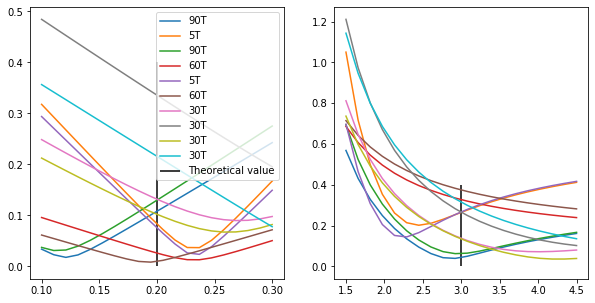

In [24]:
a_pars = np.linspace(a-a/2,a+a/2,20)
b_pars = np.linspace(b-b/2,b+b/2,20)

list_of_rmsea = []
list_of_rmseb = []

fig, ax = plt.subplots(1,2, figsize=(10,5), sharey=False)

for i, dr in enumerate(dir_paths):
    dir_path_current = Path(dr)
    agg = split_at(split_at(dr,'/',-2)[-1],'_',1)[0]
    globals()["rmsea" + agg] = []
    globals()["rmseb" + agg] = []
    list_of_rmsea.append("rmsea" + agg)
    list_of_rmseb.append("rmsea" + agg)
    beta_arr = []
    alpha_arr = []
    l_names = []
    #################
    f = open(dr + "rad_dir.txt", "r")
    for i, line in enumerate(f):
        print(line)
        rad_path_current = Path(line)
        f.close()
        break
        
    for filename in sorted(os.listdir(rad_path_current)):
        if 'alpha' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                alpha = pkl.load(f)
                alpha = alpha / 1e3
        elif 'beta' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                beta = pkl.load(f)
        elif 'hs' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                hs = pkl.load(f)
        elif 'nugget' in filename:
            with open(rad_path_current / filename, 'rb') as f:
                nugget = pkl.load(f)
    for filename in sorted(os.listdir(dir_path_current)):
        if 'ac_par' in filename:
            name = split_at(filename,'.',1)[0]
            with open(dir_path_current / filename, 'rb') as f:
                arr = pkl.load(f)
            f.close()
            arr = filter_par_arr(arr)
            arr = np.array(arr)
            arr = np.delete(arr,0,0)
            l=int(split_at(name,'_',-1)[1])
#             print(l)

            beta_arr.append(arr[:,1].T)
            alpha_arr.append(arr[:,0].T)

            l_names.append(str(l * 100))
    # sill_arr = np.concatenate(sill_arr)
    beta_arr = np.array(beta_arr)
    alpha_arr = np.array(alpha_arr)

    df_beta = pd.DataFrame(beta_arr.T,columns=l_names)
    df_alpha = pd.DataFrame(alpha_arr.T,columns=l_names)
    
#     fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=True)
#     flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
#                       linestyle='none', markeredgecolor='g')
    
    cols = df_alpha.columns.values.astype(np.float) / 1e3
    cols.astype(str)
    d = dict(zip(df_alpha.columns.values, cols))
    df_alpha.rename(columns=d, inplace=True)
    alpha_meds = df_alpha.median()
    
    for i, a_par in enumerate(a_pars):
        l_alpha_0 = []
        for i,L in enumerate(cols):
            alpha_0 = alpha_L_inv(L,
                                  a_par,
                                 df_alpha[L].median(),
                                 bias=0.0)
            l_alpha_0.append(alpha_0)
        l_alpha_0 = np.array(l_alpha_0)
        df_alpha_0 = pd.DataFrame(l_alpha_0)
        globals()["rmsea" + agg].append(rmse(df_alpha_0[0],
                                            np.ones_like(cols) * alpha) / alpha)
        
    ax[0].plot(a_pars,globals()["rmsea" + agg],label=agg)
    
    
    cols = df_beta.columns.values.astype(np.float) / 1e3
    cols.astype(str)
    d = dict(zip(df_beta.columns.values, cols))
    df_beta.rename(columns=d, inplace=True)
    beta_meds = df_beta.median()

    for i, b_par in enumerate(b_pars):
        l_beta_0 = []
        for i,L in enumerate(cols):
            beta_0 = beta_L_inv(L,
                              b_par,
                             df_beta[L].median(),
                             alpha)
            l_beta_0.append(beta_0)
        l_beta_0 = np.array(l_beta_0)
        df_beta_0 = pd.DataFrame(l_beta_0)
        globals()["rmseb" + agg].append(rmse(df_beta_0[0],
                                            np.ones_like(cols) * beta) / beta)
        bmax = np.nanmax(globals()["rmseb" + agg])
    ax[1].plot(b_pars,globals()["rmseb" + agg],label=agg)
# ax[0].set_ylim((0,8)); ax[1].set_ylim((0,8));

ax[0].vlines(a,0,0.4,label='Theoretical value')
ax[1].vlines(b,0,0.4,label='Theoretical value')
ax[0].legend()
# ax[1].legend()

#     fig.savefig(str(dir_path_current) + '/pars_agg_' + agg + '.png', bbox_inches='tight')
#     print(dir_path_current)

In [17]:
bbb = np.arange(19.1,25.1,1.1)


19.1
20.200000000000003
21.300000000000004
22.400000000000006
23.500000000000007
24.60000000000001


In [24]:
l_alpha_0 = []
for i,L in enumerate(cols):
    alpha_0 = alpha_L_inv(L,
                          0.3,
                         df_alpha[L].median())
    l_alpha_0.append(alpha_0)
    df_alpha_0 = pd.DataFrame(np.array(l_alpha_0))
    print(df_alpha[L].median(), alpha_0)

8.82324137743689 8.79324137743689
9.328162892648711 8.818162892648711
10.315894799677551 9.35589479967755
10.264763046142594 8.824763046142595
10.58579045493123 8.66579045493123
10.806869968634311 8.406869968634311
11.556931543196075 8.706931543196076
12.531018206564049 9.201018206564049
12.457985044330663 8.647985044330664
12.17205934669029 7.88205934669029
13.243523904926732 8.503523904926732
13.070189630606517 7.8501896306065175
13.485723539086681 7.785723539086681
13.290134608934107 7.110134608934106
13.501852447100532 6.871852447100532
14.206879823783787 7.096879823783787
14.36560006878571 6.77560006878571
15.6127579607599 7.542757960759902
16.281319752016646 7.761319752016647
14.709221730541705 5.709221730541705


In [27]:
df_alpha_0[0].values

array([8.79324138, 8.81816289, 9.3558948 , 8.82476305, 8.66579045,
       8.40686997, 8.70693154, 9.20101821, 8.64798504, 7.88205935,
       8.5035239 , 7.85018963, 7.78572354, 7.11013461, 6.87185245,
       7.09687982, 6.77560007, 7.54275796, 7.76131975, 5.70922173])

In [21]:
for i,L in enumerate(cols):
    alpha_0 = alpha_L_inv(L,
                          0.3,
                         df_alpha[L].median())
    print(df_alpha[L].median(), alpha_0)

8.82324137743689 8.49324137743689
9.328162892648711 8.51816289264871
10.315894799677551 9.05589479967755
10.264763046142594 8.524763046142594
10.58579045493123 8.36579045493123
10.806869968634311 8.10686996863431
11.556931543196075 8.406931543196075
12.531018206564049 8.901018206564048
12.457985044330663 8.347985044330663
12.17205934669029 7.58205934669029
13.243523904926732 8.203523904926731
13.070189630606517 7.550189630606518
13.485723539086681 7.485723539086681
13.290134608934107 6.810134608934106
13.501852447100532 6.571852447100532
14.206879823783787 6.7968798237837875
14.36560006878571 6.4756000687857105
15.6127579607599 7.242757960759902
16.281319752016646 7.461319752016647
14.709221730541705 5.409221730541705


In [21]:
nugget

9.224272582339188